## Import Library

In [1]:
import numpy as np 
import pandas as pd
# from bs4 import BeautifulSoup
import requests
import folium # map rendering library
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values
from pandas.io.json import json_normalize # handle json to dataframe
from folium.plugins import HeatMap #folium heat map

# use the inline backend to generate the plots within the browser
%matplotlib inline 

import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.style.use('ggplot') # optional: for ggplot-like style

# check for latest version of Matplotlib
print ('Matplotlib version: ', mpl.__version__) # >= 2.0.0

Matplotlib version:  3.0.3


## 1. Set up Foresquare API

In [2]:
CLIENT_ID = 'HYPHVSN5ZS2JQW33YVJPOJIFPIWQHF40JSIFJYCPO1MJLTVT' # your Foursquare ID
CLIENT_SECRET = 'CUAOMPRHQQMT4LNHU2RDPYFTNGZJ4WK5F2ISGRABAWHJYE3G' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)
address = 'Hong Kong'
latitude = 22.306
longitude = 114.19
print(latitude, longitude)

Your credentails:
CLIENT_ID: HYPHVSN5ZS2JQW33YVJPOJIFPIWQHF40JSIFJYCPO1MJLTVT
CLIENT_SECRET:CUAOMPRHQQMT4LNHU2RDPYFTNGZJ4WK5F2ISGRABAWHJYE3G
22.306 114.19


### For Simplicity, assuming that we explore hong kong restaurant near MTR lines. 

In order to neglect suburban areas, we would like to foucus the center part of the city which is well covered by the Kwun Tong Line, Island Line, part of Tsuen Wan Line and some popular stations.

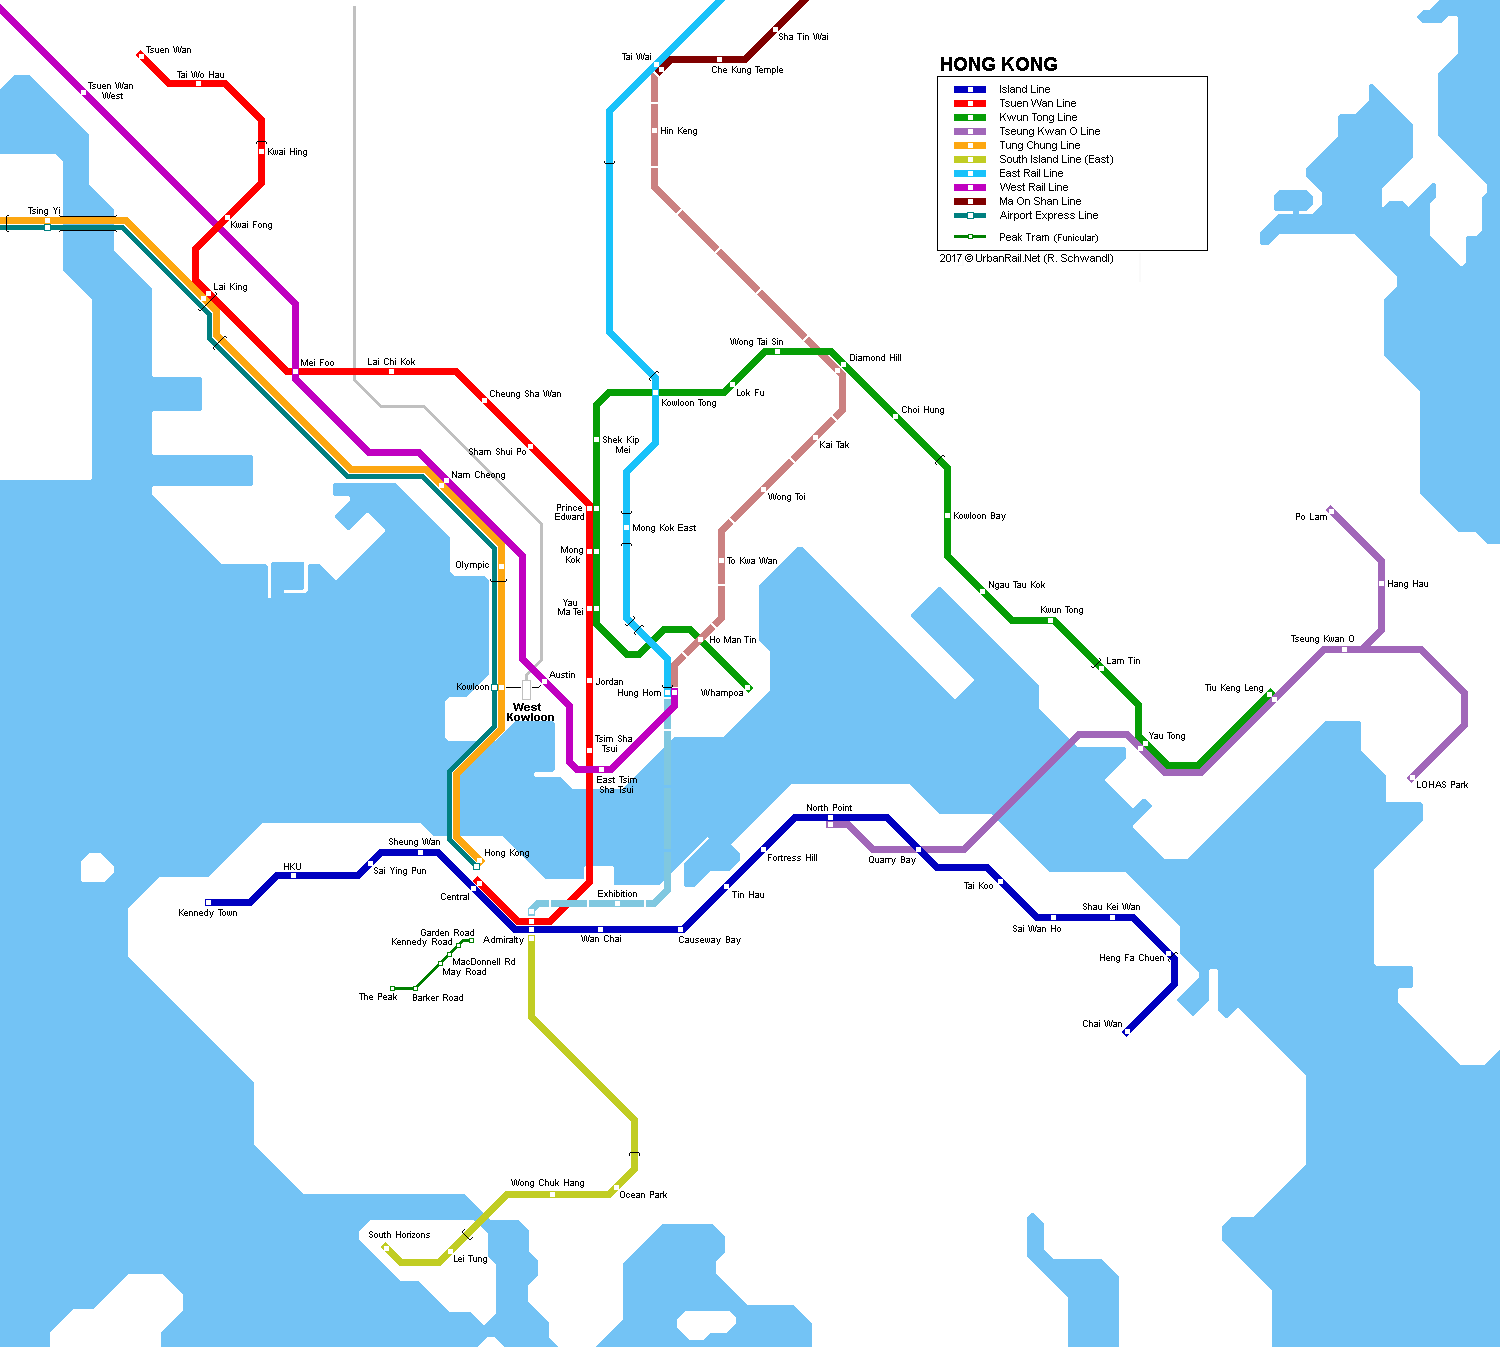

### The below station names were chosen for restaruant data acquisition.

Some stations are not recognizable by Foursquare site, we substitute them with the location name of that area.

- Whampoa -> HUNG HOM 
- HKU -> SHEK TONG TSUI
- Wan Chai -> Wanchai
- Central -> CENTRAL,HK
- Wong Tai Sin -> CHUK YUEN
- Kowloon -> Austin
-  Olympic-> Olympic,hk

In [3]:
# ----------- Kwun Tong Line + Island Line ------------
districts = {'HUNG HOM',
'Ho Man Tin',
'Yau Ma Tei',
'Mong Kok',
'Prince Edward',
'Shek Kip Mei',
'Kowloon Tong',
'Lok Fu',
'CHUK YUEN',
'Diamond Hill',
'Choi Hung',
'Kowloon Bay',
'Ngau Tau Kok',
'Kwun Tong',
'Lam Tin',
'Yau Tong',
'Kennedy Town',
'SHEK TONG TSUI',
'Sai Ying Pun',
'Sheung Wan',
'CENTRAL,HK',
'Admiralty',
'Wanchai',
'Causeway Bay',
'Tin Hau',
'Fortress Hill',
'North Point',
'Quarry Bay',
'Tai Koo',
'Sai Wan Ho',
'Shau Kei Wan',
'Heng Fa Chuen',
'Chai Wan',
'Olympic,hk',
'Tsim Sha Tsui',
'Kowloon'
}

# districts = {'Tsim Sha Tsui'}

## 2. Collecting restaurant data through Fouresquare API

#### Define a function that request the restaruant data of each station

In [4]:

def restaruant_api ( NEAR = None ):
    #categoryid 4d4b7105d754a06374d81259 is food
    categoryId = '4d4b7105d754a06374d81259'
    radius = 900
    limit = 500
    url = 'https://api.foursquare.com/v2/venues/search?client_id={}&client_secret={}&near={}&v={}&categoryId={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET,NEAR, VERSION, categoryId, radius,limit)
    url

    results = requests.get(url).json()
    # assign relevant part of JSON to venues
    print( NEAR,':' )
    venues = results['response']['venues']
    # tranform venues into a dataframe
    
    dataframe = json_normalize(venues)
    if(dataframe.shape[0] < 1):
        return  pd.DataFrame()
    dataframe.head()
    dataframe['categories'] = dataframe['categories'].apply(lambda x : x[0]['name'])
    dataframe['near'] = NEAR
    return dataframe


#### Run the function and combine all the result to hk_restaurant

In [5]:

dfs = []
for district_name in districts:
    dataframe = restaruant_api(district_name)
    dfs.append(dataframe)

hk_restaurant = pd.concat(dfs,axis = 0,sort= True)


Tin Hau :
Lam Tin :
Prince Edward :
Kowloon Tong :
Admiralty :
Causeway Bay :
Kwun Tong :
SHEK TONG TSUI :
CHUK YUEN :
Ho Man Tin :
Heng Fa Chuen :
Lok Fu :
Shek Kip Mei :
Kowloon Bay :
Kennedy Town :
Kowloon :
Choi Hung :
Diamond Hill :
Sheung Wan :
Sai Ying Pun :
Tai Koo :
Sai Wan Ho :
CENTRAL,HK :
Olympic,hk :
Ngau Tau Kok :
Tsim Sha Tsui :
Shau Kei Wan :
HUNG HOM :
Yau Ma Tei :
Wanchai :
North Point :
Yau Tong :
Fortress Hill :
Mong Kok :
Chai Wan :
Quarry Bay :


## 3. Explore Dataset:

In [6]:
hk_restaurant.head()

categories  hasPerk                        id  \
0          Coffee Shop    False  4f93fd6de4b01cffa20db610   
1         Noodle House    False  4ba74d69f964a520768a39e3   
2            BBQ Joint    False  5cc314641acf11002c58c99d   
3          Coffee Shop    False  5c124249db2aeb002b757ffd   
4  Shanghai Restaurant    False  4cea3e0dfe90a35da8aa4c0e   

                            location.address location.cc location.city  \
0  Shop D, G/F, Hung On Bldg, 2-2A King's Rd          HK            香港   
1                            13A Electric Rd          HK            香港   
2                      1 Great George Street          HK           铜锣湾   
3                              1 Lily Street          HK      Tai Hang   
4                        29 Jardine's Bazaar          HK           铜锣湾   

  location.country location.crossStreet  \
0               香港                  NaN   
1               香港                  NaN   
2               香港                  NaN   
3               香港                  NaN   
4               香港                  NaN   

                         location.formattedAddress  \
0  [Shop D, G/F, Hung On Bldg, 2-2A King's Rd, 香港]   
1                            [13A Electric Rd, 香港]   
2                      [1 Great George Street, 香港]   
3                              [1 Lily Street, 香港]   
4                        [29 Jardine's Bazaar, 香港]   

                             location.labeledLatLngs  location.lat  \
0  [{'label': 'display', 'lat': 22.28248677646355...     22.282487   
1  [{'label': 'display', 'lat': 22.2832, 'lng': 1...     22.283200   
2  [{'label': 'display', 'lat': 22.280563, 'lng':...     22.280563   
3  [{'label': 'display', 'lat': 22.279299, 'lng':...     22.279299   
4  [{'label': 'display', 'lat': 22.279531, 'lng':...     22.279531   

   location.lng location.neighborhood location.postalCode location.state  \
0    114.191935                   NaN             Tin Hau            NaN   
1    114.191504               Tin Hau                 NaN            NaN   
2    114.184936                   NaN                 NaN            NaN   
3    114.192333                   NaN                 NaN            NaN   
4    114.185089                   NaN                 NaN            NaN   

                                       name     near    referralId  \
0                           Starbucks (星巴克)  Tin Hau  v-1559411463   
1                        Sister Wah (華姐清湯腩)  Tin Hau  v-1559411463   
2                         The Charcoal Room  Tin Hau  v-1559411463   
3                                 Fineprint  Tin Hau  v-1559411463   
4  Shanghai Hong Kong Noodle House (上海香港麵家)  Tin Hau  v-1559411463   

  venuePage.id  
0          NaN  
1          NaN  
2          NaN  
3          NaN  
4          NaN

In [7]:
hk_restaurant.shape

(1749, 19)

Total 1748 rows data returned.

### Create a map of Hong Kong with restaurant superimposed on top.

In [8]:
restauran_df =hk_restaurant[['name','location.lat','location.lng','categories']]

In [9]:
food_map = folium.Map(location=[latitude, longitude], zoom_start=13)

In [10]:
# add markers to map
for lat, lng, name, categories in zip(restauran_df['location.lat'], restauran_df['location.lng'], restauran_df['name'], restauran_df['categories']):
    label = '{}, {}'.format(name, categories)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(food_map)  

food_map

Let's check how many restaurant were returned for each category

In [12]:
# overwhiling number of coffe shop
category_polt = restauran_df.groupby('categories').count().sort_values(by=['name'],ascending=False)
category_polt

name  location.lat  location.lng
categories                                                 
Coffee Shop                 213           213           213
Fast Food Restaurant        155           155           155
Chinese Restaurant          122           122           122
Cha Chaan Teng              118           118           118
Café                        105           105           105
Cantonese Restaurant         94            94            94
Hong Kong Restaurant         91            91            91
Noodle House                 77            77            77
Japanese Restaurant          57            57            57
Dim Sum Restaurant           53            53            53
Dessert Shop                 32            32            32
Italian Restaurant           31            31            31
Bakery                       31            31            31
Taiwanese Restaurant         26            26            26
Seafood Restaurant           26            26            26
Sushi Restaurant             26            26            26
Restaurant                   25            25            25
Thai Restaurant              24            24            24
Vietnamese Restaurant        23            23            23
Burger Joint                 22            22            22
Sandwich Place               21            21            21
Pizza Place                  19            19            19
Bubble Tea Shop              19            19            19
Shanghai Restaurant          19            19            19
Snack Place                  19            19            19
Asian Restaurant             16            16            16
Food Court                   15            15            15
Ramen Restaurant             14            14            14
Dumpling Restaurant          12            12            12
Malay Restaurant             12            12            12
...                         ...           ...           ...
Chinese Breakfast Place       3             3             3
Bistro                        3             3             3
Hainan Restaurant             3             3             3
Halal Restaurant              3             3             3
Fish Market                   3             3             3
Jiangsu Restaurant            3             3             3
Udon Restaurant               2             2             2
Flower Shop                   2             2             2
Indonesian Restaurant         2             2             2
Japanese Curry Restaurant     2             2             2
Tapas Restaurant              2             2             2
Taco Place                    2             2             2
Spanish Restaurant            2             2             2
Beer Bar                      1             1             1
Turkish Restaurant            1             1             1
Fish & Chips Shop             1             1             1
Lounge                        1             1             1
Soup Place                    1             1             1
Supermarket                   1             1             1
Food & Drink Shop             1             1             1
Kebab Restaurant              1             1             1
Frozen Yogurt Shop            1             1             1
Furniture / Home Store        1             1             1
German Restaurant             1             1             1
Scandinavian Restaurant       1             1             1
Satay Restaurant              1             1             1
Hawaiian Restaurant           1             1             1
Hookah Bar                    1             1             1
Hot Dog Joint                 1             1             1
Hotel Bar                     1             1             1

[91 rows x 3 columns]

### Ploting the Fequency Distribution for top 15 most common categories

In [13]:
category_polt = category_polt[:15]
category_polt = category_polt['name']
count, bin_edges = np.histogram(category_polt)
print(count) # frequency count
print(bin_edges) # bin ranges, default = 10 bins

[5 2 1 2 2 1 1 0 0 1]
[ 26.   44.7  63.4  82.1 100.8 119.5 138.2 156.9 175.6 194.3 213. ]


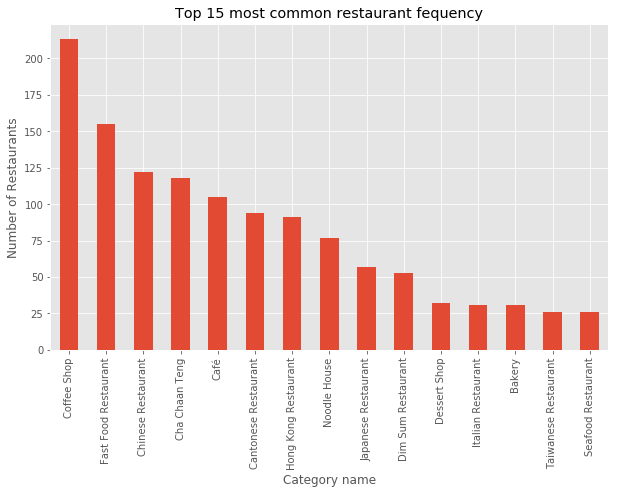

In [14]:
category_polt.plot(kind='bar', figsize=(10, 6))

plt.title('Top 15 most common restaurant fequency') # add a title to the bar chat
plt.ylabel('Number of Restaurants') # add y-label
plt.xlabel('Category name') # add x-label

plt.show()

In [15]:
print('There are {} uniques categories.'.format(len(restauran_df['categories'].unique())))

There are 91 uniques categories.


#### Short summary: 
 There are 1748 restaurants which near MTR stations and categorize into 93 groups.

## 4. Analyze Each Food Categories

### One-Hot encoding

In [16]:
# one hot encoding
restaurant_cat_onehot = pd.get_dummies(hk_restaurant[['categories']], prefix="", prefix_sep="")
# add Near column back to dataframe
restaurant_cat_onehot['Near'] = hk_restaurant['near'] 
# move Near column to the first column
fixed_columns = [restaurant_cat_onehot.columns[-1]] + list(restaurant_cat_onehot.columns[:-1])
restaurant_cat_onehot = restaurant_cat_onehot[fixed_columns]


 ### 4.1 Food categories distribution of each area

In [17]:
restaurant_group = restaurant_cat_onehot.groupby('Near').mean().reset_index()
# restaurant_group

### 4.2 Picking Top 3 categories for each area 

In [18]:
num_top_resturant = 3

for hood in restaurant_group['Near']:
    print("----"+hood+"----")
    temp = restaurant_group[restaurant_group['Near'] == hood].T.reset_index()
    temp.columns = ['resturant','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_resturant))
    print('\n')

----Admiralty----
            resturant  freq
0                Café  0.16
1         Coffee Shop  0.16
2  Dim Sum Restaurant  0.08


----CENTRAL,HK----
            resturant  freq
0         Coffee Shop  0.18
1                Café  0.14
2  Dim Sum Restaurant  0.08


----CHUK YUEN----
            resturant  freq
0  Chinese Restaurant  0.14
1      Cha Chaan Teng  0.08
2         Coffee Shop  0.08


----Causeway Bay----
              resturant  freq
0           Coffee Shop  0.28
1  Cantonese Restaurant  0.06
2    Chinese Restaurant  0.06


----Chai Wan----
              resturant  freq
0  Hong Kong Restaurant   0.1
1    Chinese Restaurant   0.1
2  Fast Food Restaurant   0.1


----Choi Hung----
              resturant  freq
0  Fast Food Restaurant  0.12
1  Cantonese Restaurant  0.10
2    Chinese Restaurant  0.08


----Diamond Hill----
              resturant  freq
0        Cha Chaan Teng  0.14
1  Hong Kong Restaurant  0.10
2           Coffee Shop  0.10


----Fortress Hill----
              re

### 4.3 Top 10 most common categories of each area 

In [19]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [20]:



num_top_resturant = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Near']
for ind in np.arange(num_top_resturant):
    try:
        columns.append('{}{} Most Common Category'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Category'.format(ind+1))

# create a new dataframe
restaurant_group_sorted = pd.DataFrame(columns=columns)
restaurant_group_sorted['Near'] = restaurant_group['Near']

for ind in np.arange(restaurant_group.shape[0]):
    restaurant_group_sorted.iloc[ind, 1:] = return_most_common_venues(restaurant_group.iloc[ind, :], num_top_resturant)

restaurant_group_sorted.head()

Near 1st Most Common Category 2nd Most Common Category  \
0     Admiralty                     Café              Coffee Shop   
1    CENTRAL,HK              Coffee Shop                     Café   
2     CHUK YUEN       Chinese Restaurant              Coffee Shop   
3  Causeway Bay              Coffee Shop           Cha Chaan Teng   
4      Chai Wan     Fast Food Restaurant     Hong Kong Restaurant   

  3rd Most Common Category 4th Most Common Category 5th Most Common Category  \
0       Dim Sum Restaurant     Fast Food Restaurant       Italian Restaurant   
1       Dim Sum Restaurant     Fast Food Restaurant             Noodle House   
2           Cha Chaan Teng     Cantonese Restaurant              Pizza Place   
3     Hong Kong Restaurant             Noodle House       Chinese Restaurant   
4       Chinese Restaurant           Cha Chaan Teng              Coffee Shop   

  6th Most Common Category 7th Most Common Category 8th Most Common Category  \
0             Noodle House           Sandwich Place             Burger Joint   
1       Italian Restaurant             Burger Joint           Sandwich Place   
2       Dim Sum Restaurant      Japanese Restaurant     Hong Kong Restaurant   
3     Cantonese Restaurant           Sandwich Place     Fast Food Restaurant   
4               Restaurant             Noodle House                Cafeteria   

  9th Most Common Category 10th Most Common Category  
0       Chinese Restaurant      Cantonese Restaurant  
1       Chinese Restaurant            Cha Chaan Teng  
2                     Café          Sushi Restaurant  
3               Restaurant          Ramen Restaurant  
4     Taiwanese Restaurant      Cantonese Restaurant

# 5.Clustering

Run *k*-means to cluster the locations into 5 clusters

In [24]:
# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

In [25]:
# set number of clusters
kclusters = 5

restaurant_group_clustering = restaurant_group.drop('Near', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(restaurant_group_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10] 

array([0, 0, 1, 2, 1, 1, 1, 1, 3, 1], dtype=int32)

In [26]:
# restaurant_group_sorted =  restaurant_group_sorted.drop(columns = 'Cluster Labels') 

In [27]:
# add clustering labels
restaurant_group_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

### 5.1 Merge Cluster labels with dataset

In [28]:

restaurant_merged = hk_restaurant

# merge toronto_grouped with toronto_data to add latitude/longitude for each neighborhood
restaurant_merged = restaurant_merged.join(restaurant_group_sorted.set_index('Near'), on='near')
restaurant_merged.head() # check the last columns!

categories  hasPerk                        id  \
0                   Burger Joint    False  58e4d9d2d0bb3e769e4bd7c2   
1           Fast Food Restaurant    False  4bf89615508c0f471cad3e31   
2           Fast Food Restaurant    False  4ca7d7a1b0b8236a11bfade6   
3                 Sandwich Place    False  542e0ccd498ec439e70a3d9e   
4  Vegetarian / Vegan Restaurant    False  4d0f5554b765224b8716e432   

                                    location.address location.cc  \
0        Shop FC01, G/F, TBG Mall, 3 Ngau Tau Kok Rd          HK   
1  Unit 246-253, G/F, Amoy Plaza 2, 77 Ngau Tau K...          HK   
2             Shop P17, Telford Plaza, 33 Wai Yip St          HK   
3                                              港鐵彩虹站          HK   
4                    Unit 242-245, G/F, Amoy Plaza 2          HK   

  location.city location.country location.crossStreet  \
0   Kowloon Bay               香港                  NaN   
1           牛头角               香港                  NaN   
2   Kowloon Bay               香港                  NaN   
3           NaN               香港                  NaN   
4           牛头角               香港   77 Ngau Tau Kok Rd   

                           location.formattedAddress  \
0  [Shop FC01, G/F, TBG Mall, 3 Ngau Tau Kok Rd, 香港]   
1  [Unit 246-253, G/F, Amoy Plaza 2, 77 Ngau Tau ...   
2       [Shop P17, Telford Plaza, 33 Wai Yip St, 香港]   
3                                        [港鐵彩虹站, 香港]   
4  [Unit 242-245, G/F, Amoy Plaza 2 (77 Ngau Tau ...   

                             location.labeledLatLngs  ...  \
0  [{'label': 'display', 'lat': 22.327194, 'lng':...  ...   
1  [{'label': 'display', 'lat': 22.32405144892984...  ...   
2  [{'label': 'display', 'lat': 22.32499990784180...  ...   
3  [{'label': 'display', 'lat': 22.33344352580358...  ...   
4  [{'label': 'display', 'lat': 22.32402746771944...  ...   

   1st Most Common Category  2nd Most Common Category  \
0      Fast Food Restaurant        Chinese Restaurant   
1      Fast Food Restaurant        Chinese Restaurant   
2      Fast Food Restaurant        Chinese Restaurant   
3      Fast Food Restaurant        Chinese Restaurant   
4      Fast Food Restaurant        Chinese Restaurant   

  3rd Most Common Category 4th Most Common Category 5th Most Common Category  \
0                     Café             Noodle House     Cantonese Restaurant   
1                     Café             Noodle House     Cantonese Restaurant   
2                     Café             Noodle House     Cantonese Restaurant   
3                     Café             Noodle House     Cantonese Restaurant   
4                     Café             Noodle House     Cantonese Restaurant   

  6th Most Common Category 7th Most Common Category 8th Most Common Category  \
0           Cha Chaan Teng              Coffee Shop      Shanghai Restaurant   
1           Cha Chaan Teng              Coffee Shop      Shanghai Restaurant   
2           Cha Chaan Teng              Coffee Shop      Shanghai Restaurant   
3           Cha Chaan Teng              Coffee Shop      Shanghai Restaurant   
4           Cha Chaan Teng              Coffee Shop      Shanghai Restaurant   

  9th Most Common Category  10th Most Common Category  
0      Japanese Restaurant       Hong Kong Restaurant  
1      Japanese Restaurant       Hong Kong Restaurant  
2      Japanese Restaurant       Hong Kong Restaurant  
3      Japanese Restaurant       Hong Kong Restaurant  
4      Japanese Restaurant       Hong Kong Restaurant  

[5 rows x 30 columns]

### 5.2 Map visualization

Finally, let's visualize the resulting clusters

In [29]:
restaurant_merged
# create map
restaurant_clusters = folium.Map(location=[latitude, longitude], zoom_start=13)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi,cat,near,cluster in zip(restaurant_merged['location.lat'], restaurant_merged['location.lng'], restaurant_merged['name'],restaurant_merged['categories'], restaurant_merged['near'], restaurant_merged['Cluster Labels']):
    label = folium.Popup(str(poi) +' Near :' + str(near) +' Cat :' +str(cat) + ' Cluster :' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(restaurant_clusters)
       
restaurant_clusters


### 5.3 Examine Clusters

In [30]:
restaurant_group_sorted.groupby('Cluster Labels').count()

Near  1st Most Common Category  2nd Most Common Category  \
Cluster Labels                                                             
0                  5                         5                         5   
1                 14                        14                        14   
2                  8                         8                         8   
3                  7                         7                         7   
4                  1                         1                         1   

                3rd Most Common Category  4th Most Common Category  \
Cluster Labels                                                       
0                                      5                         5   
1                                     14                        14   
2                                      8                         8   
3                                      7                         7   
4                                      1                         1   

                5th Most Common Category  6th Most Common Category  \
Cluster Labels                                                       
0                                      5                         5   
1                                     14                        14   
2                                      8                         8   
3                                      7                         7   
4                                      1                         1   

                7th Most Common Category  8th Most Common Category  \
Cluster Labels                                                       
0                                      5                         5   
1                                     14                        14   
2                                      8                         8   
3                                      7                         7   
4                                      1                         1   

                9th Most Common Category  10th Most Common Category  
Cluster Labels                                                       
0                                      5                          5  
1                                     14                         14  
2                                      8                          8  
3                                      7                          7  
4                                      1                          1

#### 5.3.1 1st Clusters :

In [31]:
# restaurant_merged.loc[restaurant_merged['Cluster Labels'] == 0, restaurant_merged.columns[[16]+list(range(19, restaurant_merged.shape[1]))]]
# restaurant_merged.columns
# restaurant_merged.columns

# restaurant_merged.loc[restaurant_merged['Cluster Labels'] == 0, restaurant_merged.columns[[16]+list(range(19, restaurant_merged.shape[1]))]]
restaurant_group_sorted.loc[restaurant_group_sorted['Cluster Labels'] == 0]




Cluster Labels          Near 1st Most Common Category  \
0                0     Admiralty                     Café   
1                0    CENTRAL,HK              Coffee Shop   
14               0  Kowloon Tong                     Café   
28               0    Sheung Wan              Coffee Shop   
32               0       Wanchai                     Café   

   2nd Most Common Category 3rd Most Common Category 4th Most Common Category  \
0               Coffee Shop       Dim Sum Restaurant     Fast Food Restaurant   
1                      Café       Dim Sum Restaurant     Fast Food Restaurant   
14              Coffee Shop       Chinese Restaurant     Fast Food Restaurant   
28                     Café       Dim Sum Restaurant     Cantonese Restaurant   
32              Coffee Shop     Fast Food Restaurant              Pizza Place   

   5th Most Common Category 6th Most Common Category 7th Most Common Category  \
0        Italian Restaurant             Noodle House           Sandwich Place   
1              Noodle House       Italian Restaurant             Burger Joint   
14       Italian Restaurant           Cha Chaan Teng     Hong Kong Restaurant   
28             Noodle House       Italian Restaurant      Japanese Restaurant   
32       Seafood Restaurant       Dim Sum Restaurant             Noodle House   

   8th Most Common Category 9th Most Common Category 10th Most Common Category  
0              Burger Joint       Chinese Restaurant      Cantonese Restaurant  
1            Sandwich Place       Chinese Restaurant            Cha Chaan Teng  
14                   Bakery     Taiwanese Restaurant                Restaurant  
28           Sandwich Place       Chinese Restaurant            Cha Chaan Teng  
32           Cha Chaan Teng     Cantonese Restaurant            Sandwich Place

#### 5.3.2  2nd Cluster：

In [32]:
restaurant_group_sorted.loc[restaurant_group_sorted['Cluster Labels'] == 1]

Cluster Labels           Near 1st Most Common Category  \
2                1      CHUK YUEN       Chinese Restaurant   
4                1       Chai Wan     Fast Food Restaurant   
5                1      Choi Hung     Fast Food Restaurant   
6                1   Diamond Hill           Cha Chaan Teng   
7                1  Fortress Hill     Fast Food Restaurant   
9                1  Heng Fa Chuen             Noodle House   
12               1        Kowloon       Chinese Restaurant   
15               1      Kwun Tong     Fast Food Restaurant   
16               1        Lam Tin       Chinese Restaurant   
17               1         Lok Fu           Cha Chaan Teng   
19               1   Ngau Tau Kok     Fast Food Restaurant   
20               1    North Point     Fast Food Restaurant   
21               1     Olympic,hk     Fast Food Restaurant   
26               1   Shau Kei Wan     Fast Food Restaurant   

   2nd Most Common Category 3rd Most Common Category 4th Most Common Category  \
2               Coffee Shop           Cha Chaan Teng     Cantonese Restaurant   
4      Hong Kong Restaurant       Chinese Restaurant           Cha Chaan Teng   
5      Cantonese Restaurant       Chinese Restaurant           Cha Chaan Teng   
6               Coffee Shop     Hong Kong Restaurant       Chinese Restaurant   
7            Cha Chaan Teng              Coffee Shop             Noodle House   
9      Fast Food Restaurant         Ramen Restaurant       Chinese Restaurant   
12          Thai Restaurant              Coffee Shop                     Café   
15           Cha Chaan Teng     Cantonese Restaurant              Coffee Shop   
16     Fast Food Restaurant             Noodle House     Hong Kong Restaurant   
17       Chinese Restaurant     Cantonese Restaurant             Dessert Shop   
19       Chinese Restaurant                     Café             Noodle House   
20           Cha Chaan Teng              Coffee Shop     Cantonese Restaurant   
21       Chinese Restaurant              Coffee Shop           Cha Chaan Teng   
26           Cha Chaan Teng             Noodle House             Dessert Shop   

   5th Most Common Category 6th Most Common Category 7th Most Common Category  \
2               Pizza Place       Dim Sum Restaurant      Japanese Restaurant   
4               Coffee Shop               Restaurant             Noodle House   
5        Dim Sum Restaurant     Hong Kong Restaurant         Sushi Restaurant   
6          Sushi Restaurant     Cantonese Restaurant                     Café   
7        Chinese Restaurant                     Café      Japanese Restaurant   
9                      Café          Thai Restaurant                Cafeteria   
12     Fast Food Restaurant             Noodle House           Cha Chaan Teng   
15       Chinese Restaurant     Hong Kong Restaurant                     Café   
16                   Bakery           Cha Chaan Teng      Japanese Restaurant   
17              Coffee Shop          Thai Restaurant             Noodle House   
19     Cantonese Restaurant           Cha Chaan Teng              Coffee Shop   
20     Hong Kong Restaurant             Noodle House                     Café   
21      Japanese Restaurant       Dim Sum Restaurant          Bubble Tea Shop   
26       Chinese Restaurant          Bubble Tea Shop        Indian Restaurant   

   8th Most Common Category 9th Most Common Category 10th Most Common Category  
2      Hong Kong Restaurant                     Café          Sushi Restaurant  
4                 Cafeteria     Taiwanese Restaurant      Cantonese Restaurant  
5                      Café              Coffee Shop     Vietnamese Restaurant  
6              Noodle House     Fast Food Restaurant        Dim Sum Restaurant  
7      Cantonese Restaurant                BBQ Joint        Italian Restaurant  
9      Hong Kong Restaurant               Restaurant      Cantonese Restaurant  
12             Dessert Shop       Dim Sum Restaurant          Halal Restau

#### 5.3.3  3rd Cluster：

In [33]:
restaurant_group_sorted.loc[restaurant_group_sorted['Cluster Labels'] == 2]

Cluster Labels            Near 1st Most Common Category  \
3                2    Causeway Bay              Coffee Shop   
11               2    Kennedy Town              Coffee Shop   
23               2  SHEK TONG TSUI              Coffee Shop   
25               2    Sai Ying Pun              Coffee Shop   
27               2    Shek Kip Mei              Coffee Shop   
30               2         Tin Hau              Coffee Shop   
31               2   Tsim Sha Tsui              Coffee Shop   
33               2      Yau Ma Tei              Coffee Shop   

   2nd Most Common Category 3rd Most Common Category 4th Most Common Category  \
3            Cha Chaan Teng     Hong Kong Restaurant             Noodle House   
11           Cha Chaan Teng                Gastropub     Fast Food Restaurant   
23       Chinese Restaurant        French Restaurant                Gastropub   
25     Cantonese Restaurant       Chinese Restaurant       Italian Restaurant   
27           Cha Chaan Teng             Noodle House             Dessert Shop   
30                     Café           Cha Chaan Teng     Fast Food Restaurant   
31     Fast Food Restaurant           Cha Chaan Teng             Noodle House   
33     Fast Food Restaurant       Chinese Restaurant     Hong Kong Restaurant   

   5th Most Common Category 6th Most Common Category 7th Most Common Category  \
3        Chinese Restaurant     Cantonese Restaurant           Sandwich Place   
11       Chinese Restaurant       Mexican Restaurant           Breakfast Spot   
23       Mexican Restaurant       Dim Sum Restaurant                   Bakery   
25                     Café        French Restaurant         Tapas Restaurant   
27       Chinese Restaurant              Snack Place       Dim Sum Restaurant   
30             Noodle House     Hong Kong Restaurant                BBQ Joint   
31             Dessert Shop      Shanghai Restaurant              Snack Place   
33           Cha Chaan Teng       Dim Sum Restaurant             Dessert Shop   

   8th Most Common Category 9th Most Common Category 10th Most Common Category  
3      Fast Food Restaurant               Restaurant          Ramen Restaurant  
11       Dim Sum Restaurant                     Café        English Restaurant  
23           Cha Chaan Teng     Cantonese Restaurant            Breakfast Spot  
25      Japanese Restaurant                   Bakery              Noodle House  
27                     Café                   Bakery       Dumpling Restaurant  
30       Chinese Restaurant      Japanese Restaurant      Cantonese Restaurant  
31          Bubble Tea Shop         Ramen Restaurant        Dim Sum Restaurant  
33             Noodle House     Cantonese Restaurant       Shanghai Restaurant

#### 5.3.4  4th Cluster：

In [34]:
restaurant_group_sorted.loc[restaurant_group_sorted['Cluster Labels'] == 3]

Cluster Labels         Near 1st Most Common Category  \
8                3     HUNG HOM              Coffee Shop   
10               3   Ho Man Tin              Coffee Shop   
13               3  Kowloon Bay              Coffee Shop   
18               3     Mong Kok              Coffee Shop   
22               3   Quarry Bay     Fast Food Restaurant   
24               3   Sai Wan Ho              Coffee Shop   
29               3      Tai Koo              Coffee Shop   

   2nd Most Common Category 3rd Most Common Category 4th Most Common Category  \
8      Fast Food Restaurant     Hong Kong Restaurant       Chinese Restaurant   
10     Hong Kong Restaurant     Fast Food Restaurant     Cantonese Restaurant   
13     Fast Food Restaurant       Chinese Restaurant     Hong Kong Restaurant   
18     Fast Food Restaurant     Hong Kong Restaurant     Cantonese Restaurant   
22              Coffee Shop     Cantonese Restaurant     Hong Kong Restaurant   
24     Fast Food Restaurant      Japanese Restaurant     Cantonese Restaurant   
29     Cantonese Restaurant     Fast Food Restaurant      Japanese Restaurant   

   5th Most Common Category 6th Most Common Category 7th Most Common Category  \
8      Cantonese Restaurant                     Café      Japanese Restaurant   
10       Chinese Restaurant       Italian Restaurant           Cha Chaan Teng   
13     Cantonese Restaurant      Japanese Restaurant                     Café   
18       Chinese Restaurant       Dim Sum Restaurant      Japanese Restaurant   
22      Japanese Restaurant                     Café    Vietnamese Restaurant   
24                     Café     Hong Kong Restaurant           Cha Chaan Teng   
29           Cha Chaan Teng                     Café     Hong Kong Restaurant   

   8th Most Common Category 9th Most Common Category 10th Most Common Category  
8          Sushi Restaurant             Noodle House            Cha Chaan Teng  
10      Shanghai Restaurant          Bubble Tea Shop         Hotpot Restaurant  
13             Noodle House           Cha Chaan Teng       Shanghai Restaurant  
18               Steakhouse             Dessert Shop            Cha Chaan Teng  
22             Burger Joint           Cha Chaan Teng      Taiwanese Restaurant  
24    Vietnamese Restaurant       Dim Sum Restaurant              Noodle House  
29    Vietnamese Restaurant     Taiwanese Restaurant   New American Restaurant

#### 5.3.5  5th Cluster：

In [35]:
restaurant_group_sorted.loc[restaurant_group_sorted['Cluster Labels'] == 4]

Cluster Labels      Near 1st Most Common Category  \
34               4  Yau Tong       Seafood Restaurant   

   2nd Most Common Category 3rd Most Common Category 4th Most Common Category  \
34     Fast Food Restaurant       Chinese Restaurant                     Café   

   5th Most Common Category 6th Most Common Category 7th Most Common Category  \
34                   Bakery      Japanese Restaurant           Cha Chaan Teng   

   8th Most Common Category 9th Most Common Category 10th Most Common Category  
34        Korean Restaurant                Juice Bar        Donburi Restaurant

In [39]:
restaurant_cat_onehot = restaurant_cat_onehot.join(restaurant_group_sorted.set_index('Near'), on='Near')
restaurant_cat_onehot.head() # check the last columns!

Near  American Restaurant  Asian Restaurant  Australian Restaurant  \
0  Ngau Tau Kok                    0                 0                      0   
1  Ngau Tau Kok                    0                 0                      0   
2  Ngau Tau Kok                    0                 0                      0   
3  Ngau Tau Kok                    0                 0                      0   
4  Ngau Tau Kok                    0                 0                      0   

   BBQ Joint  Bakery  Beer Bar  Beijing Restaurant  Belgian Restaurant  \
0          0       0         0                   0                   0   
1          0       0         0                   0                   0   
2          0       0         0                   0                   0   
3          0       0         0                   0                   0   
4          0       0         0                   0                   0   

   Bistro  ...  1st Most Common Category  2nd Most Common Category  \
0       0  ...      Fast Food Restaurant        Chinese Restaurant   
1       0  ...      Fast Food Restaurant        Chinese Restaurant   
2       0  ...      Fast Food Restaurant        Chinese Restaurant   
3       0  ...      Fast Food Restaurant        Chinese Restaurant   
4       0  ...      Fast Food Restaurant        Chinese Restaurant   

   3rd Most Common Category  4th Most Common Category  \
0                      Café              Noodle House   
1                      Café              Noodle House   
2                      Café              Noodle House   
3                      Café              Noodle House   
4                      Café              Noodle House   

   5th Most Common Category  6th Most Common Category  \
0      Cantonese Restaurant            Cha Chaan Teng   
1      Cantonese Restaurant            Cha Chaan Teng   
2      Cantonese Restaurant            Cha Chaan Teng   
3      Cantonese Restaurant            Cha Chaan Teng   
4      Cantonese Restaurant            Cha Chaan Teng   

   7th Most Common Category  8th Most Common Category  \
0               Coffee Shop       Shanghai Restaurant   
1               Coffee Shop       Shanghai Restaurant   
2               Coffee Shop       Shanghai Restaurant   
3               Coffee Shop       Shanghai Restaurant   
4               Coffee Shop       Shanghai Restaurant   

   9th Most Common Category  10th Most Common Category  
0       Japanese Restaurant       Hong Kong Restaurant  
1       Japanese Restaurant       Hong Kong Restaurant  
2       Japanese Restaurant       Hong Kong Restaurant  
3       Japanese Restaurant       Hong Kong Restaurant  
4       Japanese Restaurant       Hong Kong Restaurant  

[5 rows x 103 columns]

In [40]:
restaurant_cluster = restaurant_cat_onehot.groupby('Cluster Labels').mean().reset_index()
restaurant_cluster

Cluster Labels  American Restaurant  Asian Restaurant  \
0               0             0.016000          0.012000   
1               1             0.000000          0.011429   
2               2             0.005000          0.005000   
3               3             0.014286          0.008571   
4               4             0.000000          0.000000   

   Australian Restaurant  BBQ Joint    Bakery  Beer Bar  Beijing Restaurant  \
0                  0.008   0.004000  0.024000  0.000000            0.000000   
1                  0.000   0.007143  0.015714  0.000000            0.000000   
2                  0.005   0.005000  0.020000  0.000000            0.007500   
3                  0.000   0.005714  0.011429  0.002857            0.011429   
4                  0.000   0.000000  0.040816  0.000000            0.000000   

   Belgian Restaurant    Bistro  ...  Taco Place  Taiwanese Restaurant  \
0            0.000000  0.000000  ...       0.000              0.008000   
1            0.000000  0.001429  ...       0.000              0.018571   
2            0.000000  0.000000  ...       0.005              0.007500   
3            0.008571  0.002857  ...       0.000              0.022857   
4            0.000000  0.020408  ...       0.000              0.000000   

   Tapas Restaurant  Tea Room  Thai Restaurant  Turkish Restaurant  \
0             0.000  0.000000         0.004000            0.000000   
1             0.000  0.005714         0.028571            0.000000   
2             0.005  0.002500         0.005000            0.000000   
3             0.000  0.000000         0.000000            0.002857   
4             0.000  0.000000         0.020408            0.000000   

   Udon Restaurant  Vegetarian / Vegan Restaurant  Vietnamese Restaurant  \
0         0.000000                       0.000000               0.004000   
1         0.002857                       0.008571               0.012857   
2         0.000000                       0.007500               0.010000   
3         0.000000                       0.002857               0.025714   
4         0.000000                       0.000000               0.000000   

   Wings Joint  
0     0.000000  
1     0.001429  
2     0.005000  
3     0.000000  
4     0.000000  

[5 rows x 92 columns]

#### 5.3.6 listing top 30 restaurants for each Cluster

In [41]:
num_top_resturant = 30

for hood in restaurant_cluster['Cluster Labels']:
    print("---- Cluster "+str(hood)+": ----")
    temp = restaurant_cluster[restaurant_cluster['Cluster Labels'] == hood].T.reset_index()
    temp.columns = ['resturant','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_resturant))
    print('\n')

---- Cluster 0: ----
                     resturant  freq
0                  Coffee Shop  0.17
1                         Café  0.15
2         Fast Food Restaurant  0.06
3           Dim Sum Restaurant  0.06
4                 Noodle House  0.05
5           Italian Restaurant  0.05
6         Cantonese Restaurant  0.04
7               Sandwich Place  0.04
8         Hong Kong Restaurant  0.04
9           Chinese Restaurant  0.04
10              Cha Chaan Teng  0.04
11                Burger Joint  0.03
12         Japanese Restaurant  0.02
13                  Restaurant  0.02
14                      Bakery  0.02
15         American Restaurant  0.02
16   Middle Eastern Restaurant  0.01
17       Australian Restaurant  0.01
18          Mexican Restaurant  0.01
19            Asian Restaurant  0.01
20                 Pizza Place  0.01
21              Ice Cream Shop  0.01
22                   Juice Bar  0.01
23         Shanghai Restaurant  0.01
24          Seafood Restaurant  0.01
25        Taiwane

### 5.4 Insight from restaurant Clustering

- Blue Cluster 0 : Office Area with more western cuisine
- Purple Cluster 1: Fairly distributed Food Area
- Red Cluster 2 : Working or Shopping Area
- Light Blue Cluster 3: Asian Food Cluster
- Yellow Cluster 4 : Seafood intensive Area 

### 5.5  Categories Distribution

In [42]:
restauran_df.groupby('categories').count().sort_values(by=['name'],ascending=False)

name  location.lat  location.lng
categories                                                 
Coffee Shop                 213           213           213
Fast Food Restaurant        155           155           155
Chinese Restaurant          122           122           122
Cha Chaan Teng              118           118           118
Café                        105           105           105
Cantonese Restaurant         94            94            94
Hong Kong Restaurant         91            91            91
Noodle House                 77            77            77
Japanese Restaurant          57            57            57
Dim Sum Restaurant           53            53            53
Dessert Shop                 32            32            32
Italian Restaurant           31            31            31
Bakery                       31            31            31
Taiwanese Restaurant         26            26            26
Seafood Restaurant           26            26            26
Sushi Restaurant             26            26            26
Restaurant                   25            25            25
Thai Restaurant              24            24            24
Vietnamese Restaurant        23            23            23
Burger Joint                 22            22            22
Sandwich Place               21            21            21
Pizza Place                  19            19            19
Bubble Tea Shop              19            19            19
Shanghai Restaurant          19            19            19
Snack Place                  19            19            19
Asian Restaurant             16            16            16
Food Court                   15            15            15
Ramen Restaurant             14            14            14
Dumpling Restaurant          12            12            12
Malay Restaurant             12            12            12
...                         ...           ...           ...
Chinese Breakfast Place       3             3             3
Bistro                        3             3             3
Hainan Restaurant             3             3             3
Halal Restaurant              3             3             3
Fish Market                   3             3             3
Jiangsu Restaurant            3             3             3
Udon Restaurant               2             2             2
Flower Shop                   2             2             2
Indonesian Restaurant         2             2             2
Japanese Curry Restaurant     2             2             2
Tapas Restaurant              2             2             2
Taco Place                    2             2             2
Spanish Restaurant            2             2             2
Beer Bar                      1             1             1
Turkish Restaurant            1             1             1
Fish & Chips Shop             1             1             1
Lounge                        1             1             1
Soup Place                    1             1             1
Supermarket                   1             1             1
Food & Drink Shop             1             1             1
Kebab Restaurant              1             1             1
Frozen Yogurt Shop            1             1             1
Furniture / Home Store        1             1             1
German Restaurant             1             1             1
Scandinavian Restaurant       1             1             1
Satay Restaurant              1             1             1
Hawaiian Restaurant           1             1             1
Hookah Bar                    1             1             1
Hot Dog Joint                 1             1             1
Hotel Bar                     1             1             1

[91 rows x 3 columns]

## 6. Analyzing Price Distribution

### 6.1 Data Punching 

In order to exclude some meaningless data, we apply data punching to restaurant data prepared above.

Some restaurant types have standard pricing or normally cheap which will not contribute much to that area of restaruant. Therefore we will ignore those data.


In [43]:
restaurant_punch = restaurant_merged
restaurant_punch = restaurant_punch[restaurant_punch['categories'] != 'Coffee Shop' ]
restaurant_punch = restaurant_punch[restaurant_punch['categories'] != 'Café' ]
restaurant_punch = restaurant_punch[restaurant_punch['categories'] != 'Fast Food Restaurant' ]
restaurant_punch = restaurant_punch[restaurant_punch['categories'] != 'Cha Chaan Teng' ]
restaurant_punch = restaurant_punch[restaurant_punch['categories'] != 'Chinese Restaurant' ]
restaurant_punch = restaurant_punch[restaurant_punch['categories'] != 'Hong Kong Restaurant' ]
# chinese_rest = restauran_df[restauran_df['categories']=='Dim Sum Restaurant']
# Japanese Restaurant
# French Restaurant
# Café

## 6.2 Data visualization

#### food_map = folium.Map(location=[latitude, longitude], zoom_start=13)

In [45]:
# add markers to map
for lat, lng, name, categories in zip(restaurant_punch['location.lat'], restaurant_punch['location.lng'], restaurant_punch['name'], restaurant_punch['categories']):
    label = '{}, {}'.format(name, categories)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(food_map)  

food_map

In [95]:
restaurant_punch.shape

(945, 34)

## 6.3 Get details information from Foursquare API

In [96]:
def try_catch(x,a):
    result = ''
    try: 
        result = x[a]
#         print('catch: ',result )
    except: 
        result = None
    return result


restaurant_punch['rating'] = ''
restaurant_punch['checkins'] = ''
restaurant_punch['price_tier'] = ''
restaurant_punch['price'] = ''
# restaurant_punch['attributes'] = ''

In [97]:
restaurant_details = restaurant_punch
restaurant_details

categories  hasPerk                        id  \
0                    Burger Joint    False  58e4d9d2d0bb3e769e4bd7c2   
3                  Sandwich Place    False  542e0ccd498ec439e70a3d9e   
4   Vegetarian / Vegan Restaurant    False  4d0f5554b765224b8716e432   
5                    Dessert Shop    False  4be390fdfe299521ca9a966c   
6                       BBQ Joint    False  5b9bb34ab77c77002ce24388   
8                Ramen Restaurant    False  511b92dfe4b0cf59f1643cd4   
9                Hakka Restaurant    False  55161ce1498ed951dc8456ed   
12                         Bakery    False  53edeca8498e6ff5ac6057d0   
13           Cantonese Restaurant    False  4bff35f34e5d0f478be17d1f   
14            Shanghai Restaurant    False  5937e16cf79faa70e69586c3   
16                    Snack Place    False  5b8645eb04d1ae002c8d70b3   
17                   Noodle House    False  53461f9f498ec88df1490b55   
18          Vietnamese Restaurant    False  59ae34cb0868a23a1e97792e   
19               Sushi Restaurant    False  4e5e1d38e4cdfc603ed5eb09   
20             Italian Restaurant    False  5aa8b30aa4b51b492a3691bd   
24            Shanghai Restaurant    False  581f130287dde547fb136671   
26                Bubble Tea Shop    False  5b8653a097cf5a002c70cabb   
28                   Noodle House    False  50b89992e4b07607366498e1   
31             Dim Sum Restaurant    False  5a125bb48b98fd70843a6115   
32            Japanese Restaurant    False  4dd3aff78877a55425c0f7df   
33           Taiwanese Restaurant    False  556488e5498e2140c8b6ff4e   
37                     Food Court    False  4d9d636cc99fb60c3d71c68b   
39                   Noodle House    False  510b55b3e4b0256d6982d02a   
41           Cantonese Restaurant    False  4bf7693ab182c9b646d0755a   
43               Asian Restaurant    False  4cbfc57b97bc721e23b88767   
44           Cantonese Restaurant    False  5b9a0fa5c8b2fb002caa30a8   
46            Japanese Restaurant    False  58c37db752a051100e0731ac   
0               Food & Drink Shop    False  55c6e84b498e0dc25361ec7c   
1                  Sandwich Place    False  4b0588cff964a52021db22e3   
2                          Bakery    False  4cca0f259b934688c4554c41   
..                            ...      ...                       ...   
1                      Restaurant    False  55a2938e498e1ef2edab6ddc   
3                     Pizza Place    False  5472b40a498e0831c4a57d29   
4             Japanese Restaurant    False  585a81e8076be167f6e8c67c   
6           Vietnamese Restaurant    False  586396c8469aef7d53f80ea6   
7                    Burger Joint    False  559cd583498e2b027bdbb495   
9               Hainan Restaurant    False  55c5e85f498e81ab630e00de   
10                         Bakery    False  5b9cf3ffa30619002cdc1ded   
11           Taiwanese Restaurant    False  58fc95ad50a6f05953c50b43   
13            Japanese Restaurant    False  5b36ec0d3092be002ca5083f   
19             Jiangsu Restaurant    False  585a8173fc5a5f12a7c39651   
20                     Food Court    False  584a7451730a9237928b92d9   
22              Korean Restaurant    False  4cf5cfa3e308236a05f1e2ac   
23           Cantonese Restaurant    False  4c46d8cb417b20a154a6dba9   
25                 Ice Cream Shop    False  5c7f62ac73fe25002bb9f049   
26            Japanese Restaurant    False  4bad8f33f964a5207d5b3be3   
27           Cantonese Restaurant    False  576fb755498e091a4fc71fe9   
28                    Snack Place    False  4d204ef416cfb60cff265861   
29                   Noodle House    False  4be689b62468c928b37b0143   
30             Dim Sum Restaurant    False  4c78f85293ef236aefe1ad0f   
31           Cantonese Restaurant    False  59d08dd31213840f7c7014a7   
35             Belgian Restaurant    False  4cdcca7fc409b60c89d1dc1a   
36             Seafood Restaurant    False  4b7cdac2f964a5207ca72fe3   
40            Japanese Restaurant    False  55750ffc498e2a6bb6987de1   
42             Italian Restaurant    False  5754fbb3498e6ea32b8

In [ ]:
for index_label, row_series in restaurant_details.iterrows():
    url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}'.format(row_series['id'],CLIENT_ID, CLIENT_SECRET, VERSION)
    json = requests.get(url).json()
    venue = json['response']['venue']
    restaurant_details.at[index_label , 'rating'] = try_catch(venue,'rating')
    restaurant_details.at[index_label , 'price'] = try_catch(try_catch(venue,'price'),'message')
    restaurant_details.at[index_label , 'price_tier'] = try_catch(try_catch(venue,'price'),'tier')
    restaurant_details.at[index_label , 'checkins'] = try_catch(try_catch(venue,'stats'),'checkinsCount')
#     restaurant_details.at[index_label , 'attributes'] = try_catch(try_catch(venue,'attributes'),'groups')    
 
    
    
#     dataframe.at[index_label , 'respon'] = requests.get(url).json()
#     url = 'https://api.foursquare.com/v2/venues/{}?client_id={}&client_secret={}&v={}&categoryId={}&radius={}&limit={}'.format(id,CLIENT_ID, CLIENT_SECRET, VERSION, categoryId, radius, LIMIT)



## 6.4 Price Details Ready

In [50]:
# url_df= url_df.drop(columns={'api_url'})
restaurant_details

categories  hasPerk                        id  \
0                    Burger Joint    False  58e4d9d2d0bb3e769e4bd7c2   
3                  Sandwich Place    False  542e0ccd498ec439e70a3d9e   
4   Vegetarian / Vegan Restaurant    False  4d0f5554b765224b8716e432   
5                    Dessert Shop    False  4be390fdfe299521ca9a966c   
6                       BBQ Joint    False  5b9bb34ab77c77002ce24388   
8                Ramen Restaurant    False  511b92dfe4b0cf59f1643cd4   
9                Hakka Restaurant    False  55161ce1498ed951dc8456ed   
12                         Bakery    False  53edeca8498e6ff5ac6057d0   
13           Cantonese Restaurant    False  4bff35f34e5d0f478be17d1f   
14            Shanghai Restaurant    False  5937e16cf79faa70e69586c3   
16                    Snack Place    False  5b8645eb04d1ae002c8d70b3   
17                   Noodle House    False  53461f9f498ec88df1490b55   
18          Vietnamese Restaurant    False  59ae34cb0868a23a1e97792e   
19               Sushi Restaurant    False  4e5e1d38e4cdfc603ed5eb09   
20             Italian Restaurant    False  5aa8b30aa4b51b492a3691bd   
24            Shanghai Restaurant    False  581f130287dde547fb136671   
26                Bubble Tea Shop    False  5b8653a097cf5a002c70cabb   
28                   Noodle House    False  50b89992e4b07607366498e1   
31             Dim Sum Restaurant    False  5a125bb48b98fd70843a6115   
32            Japanese Restaurant    False  4dd3aff78877a55425c0f7df   
33           Taiwanese Restaurant    False  556488e5498e2140c8b6ff4e   
37                     Food Court    False  4d9d636cc99fb60c3d71c68b   
39                   Noodle House    False  510b55b3e4b0256d6982d02a   
41           Cantonese Restaurant    False  4bf7693ab182c9b646d0755a   
43               Asian Restaurant    False  4cbfc57b97bc721e23b88767   
44           Cantonese Restaurant    False  5b9a0fa5c8b2fb002caa30a8   
46            Japanese Restaurant    False  58c37db752a051100e0731ac   
0               Food & Drink Shop    False  55c6e84b498e0dc25361ec7c   
1                  Sandwich Place    False  4b0588cff964a52021db22e3   
2                          Bakery    False  4cca0f259b934688c4554c41   
..                            ...      ...                       ...   
1                      Restaurant    False  55a2938e498e1ef2edab6ddc   
3                     Pizza Place    False  5472b40a498e0831c4a57d29   
4             Japanese Restaurant    False  585a81e8076be167f6e8c67c   
6           Vietnamese Restaurant    False  586396c8469aef7d53f80ea6   
7                    Burger Joint    False  559cd583498e2b027bdbb495   
9               Hainan Restaurant    False  55c5e85f498e81ab630e00de   
10                         Bakery    False  5b9cf3ffa30619002cdc1ded   
11           Taiwanese Restaurant    False  58fc95ad50a6f05953c50b43   
13            Japanese Restaurant    False  5b36ec0d3092be002ca5083f   
19             Jiangsu Restaurant    False  585a8173fc5a5f12a7c39651   
20                     Food Court    False  584a7451730a9237928b92d9   
22              Korean Restaurant    False  4cf5cfa3e308236a05f1e2ac   
23           Cantonese Restaurant    False  4c46d8cb417b20a154a6dba9   
25                 Ice Cream Shop    False  5c7f62ac73fe25002bb9f049   
26            Japanese Restaurant    False  4bad8f33f964a5207d5b3be3   
27           Cantonese Restaurant    False  576fb755498e091a4fc71fe9   
28                    Snack Place    False  4d204ef416cfb60cff265861   
29                   Noodle House    False  4be689b62468c928b37b0143   
30             Dim Sum Restaurant    False  4c78f85293ef236aefe1ad0f   
31           Cantonese Restaurant    False  59d08dd31213840f7c7014a7   
35             Belgian Restaurant    False  4cdcca7fc409b60c89d1dc1a   
36             Seafood Restaurant    False  4b7cdac2f964a5207ca72fe3   
40            Japanese Restaurant    False  55750ffc498e2a6bb6987de1   
42             Italian Restaurant    False  5754fbb3498e6ea32b8

### 6.4.1 Save and Load dataset

In order to save API Quota, we can only run this once in a day.

In [51]:
restaurant_details.to_csv('restaurant_price_clusters.csv')

In [92]:
restaurant_details = pd.read_csv('restaurant_price_clusters.csv')

## 6.5 Average restaruant price tier (0 - 3)

In [94]:
restaurant_details['price_tier'].mean()

nan

In [54]:
restaurant_details

Unnamed: 0                     categories  hasPerk  \
0             0                   Burger Joint    False   
1             3                 Sandwich Place    False   
2             4  Vegetarian / Vegan Restaurant    False   
3             5                   Dessert Shop    False   
4             6                      BBQ Joint    False   
5             8               Ramen Restaurant    False   
6             9               Hakka Restaurant    False   
7            12                         Bakery    False   
8            13           Cantonese Restaurant    False   
9            14            Shanghai Restaurant    False   
10           16                    Snack Place    False   
11           17                   Noodle House    False   
12           18          Vietnamese Restaurant    False   
13           19               Sushi Restaurant    False   
14           20             Italian Restaurant    False   
15           24            Shanghai Restaurant    False   
16           26                Bubble Tea Shop    False   
17           28                   Noodle House    False   
18           31             Dim Sum Restaurant    False   
19           32            Japanese Restaurant    False   
20           33           Taiwanese Restaurant    False   
21           37                     Food Court    False   
22           39                   Noodle House    False   
23           41           Cantonese Restaurant    False   
24           43               Asian Restaurant    False   
25           44           Cantonese Restaurant    False   
26           46            Japanese Restaurant    False   
27            0              Food & Drink Shop    False   
28            1                 Sandwich Place    False   
29            2                         Bakery    False   
..          ...                            ...      ...   
915           1                     Restaurant    False   
916           3                    Pizza Place    False   
917           4            Japanese Restaurant    False   
918           6          Vietnamese Restaurant    False   
919           7                   Burger Joint    False   
920           9              Hainan Restaurant    False   
921          10                         Bakery    False   
922          11           Taiwanese Restaurant    False   
923          13            Japanese Restaurant    False   
924          19             Jiangsu Restaurant    False   
925          20                     Food Court    False   
926          22              Korean Restaurant    False   
927          23           Cantonese Restaurant    False   
928          25                 Ice Cream Shop    False   
929          26            Japanese Restaurant    False   
930          27           Cantonese Restaurant    False   
931          28                    Snack Place    False   
932          29                   Noodle House    False   
933          30             Dim Sum Restaurant    False   
934          31           Cantonese Restaurant    False   
935          35             Belgian Restaurant    False   
936          36             Seafood Restaurant    False   
937          40            Japanese Restaurant    False   
938          42             Italian Restaurant    False   
939          43            American Restaurant    False   
940          45          Vietnamese Restaurant    False   
941          46                   Noodle House    False   
942          47             Dim Sum Restaurant    False   
943          48           Cantonese Restaurant    False   
944          49             Beijing Restaurant    False   

                           id  \
0    58e4d9d2d0bb3e769e4bd7c2   
1    542e0ccd498ec439e70a3d9e   
2    4d0f5554b765224b8716e432   
3    4be390fdfe299521ca9a966c   
4    5b9bb34ab77c77002ce24388   
5    511b92dfe4b0cf59f1643cd4   
6    55161ce1498ed951dc8456ed   
7    53edeca8498e6ff5ac6057d0   
8    4bff35f34e5d0f478be17d1f   
9    5937e16cf79

## 6.6 Handling Missing data

Price tier information contains missing value, therefore we need to handle the mssing value. 

In order to minimize the impact of data cleansing, we adopt the category's means as the new value.

### 6.6.1 Perparing category's means figure

In [55]:
# create categories price_tier mean
# fill missing categories with mean 
price_categories_ref = restaurant_details.groupby('categories').mean()
price_categories_ref = price_categories_ref[ 'price_tier'].reset_index()
price_categories_ref = price_categories_ref.fillna(restaurant_details['price_tier'].mean())
price_categories_ref 



# price_categories_ref[price_categories_ref['categories'] =='American Restaurant ' ]
# restaurant_details.groupby('categories').count()
# price_cluster.sort_values(by=['price_tier'],ascending=False)

categories  price_tier
0             American Restaurant         NaN
1                Asian Restaurant         NaN
2           Australian Restaurant         NaN
3                       BBQ Joint         NaN
4                          Bakery         NaN
5                        Beer Bar         NaN
6              Beijing Restaurant         NaN
7              Belgian Restaurant         NaN
8                          Bistro         NaN
9                  Breakfast Spot         NaN
10                Bubble Tea Shop         NaN
11                         Buffet         NaN
12                   Burger Joint         NaN
13                      Cafeteria         NaN
14           Cantonese Restaurant         NaN
15        Chinese Breakfast Place         NaN
16                   Dessert Shop         NaN
17             Dim Sum Restaurant         NaN
18                          Diner         NaN
19             Donburi Restaurant         NaN
20            Dumpling Restaurant         NaN
21             English Restaurant         NaN
22              Fish & Chips Shop         NaN
23                    Fish Market         NaN
24                    Flower Shop         NaN
25              Food & Drink Shop         NaN
26                     Food Court         NaN
27              French Restaurant         NaN
28            Fried Chicken Joint         NaN
29             Frozen Yogurt Shop         NaN
..                            ...         ...
55      Middle Eastern Restaurant         NaN
56     Modern European Restaurant         NaN
57        New American Restaurant         NaN
58                   Noodle House         NaN
59                    Pizza Place         NaN
60               Ramen Restaurant         NaN
61                     Restaurant         NaN
62                    Salad Place         NaN
63                 Sandwich Place         NaN
64               Satay Restaurant         NaN
65        Scandinavian Restaurant         NaN
66             Seafood Restaurant         NaN
67            Shanghai Restaurant         NaN
68                    Snack Place         NaN
69                     Soup Place         NaN
70             Spanish Restaurant         NaN
71                     Steakhouse         NaN
72                    Supermarket         NaN
73               Sushi Restaurant         NaN
74            Szechuan Restaurant         NaN
75                     Taco Place         NaN
76           Taiwanese Restaurant         NaN
77               Tapas Restaurant         NaN
78                       Tea Room         NaN
79                Thai Restaurant         NaN
80             Turkish Restaurant         NaN
81                Udon Restaurant         NaN
82  Vegetarian / Vegan Restaurant         NaN
83          Vietnamese Restaurant         NaN
84                    Wings Joint         NaN

[85 rows x 2 columns]

### 6.6.2 Data Cleaning

In [56]:
# price cleaning
restaurant_details_clean = restaurant_details[:0]
for cat in price_categories_ref['categories']:
    cat_mean = price_categories_ref.loc[price_categories_ref['categories'] == cat]['price_tier'].item()
    cat_clean_df = restaurant_details[restaurant_details['categories'] == cat]
    cat_clean_df = cat_clean_df.fillna( cat_mean)
#     cat_clean_df['price_tier_'] = cat_clean_col['price_tier']
    
#     print ('mean : ', cat_mean)
#     print (cat_clean_df['price_tier'])
#     price_categories_ref.loc[price_categories_ref['categories'] == cat, 'price_tier' ] 
    restaurant_details_clean = restaurant_details_clean.append(cat_clean_df)
#     restaurant_details_clean = restaurant_details_clean.append(restaurant_details[restaurant_details['categories'] == cat].fillna( price_categories_ref.loc[price_categories_ref['categories'] == cat, 'price_tier' ] ))



In [57]:
restaurant_details_clean

Unnamed: 0                     categories  hasPerk  \
30            6            American Restaurant    False   
172          32            American Restaurant    False   
179           0            American Restaurant    False   
308          48            American Restaurant    False   
519          26            American Restaurant    False   
562          46            American Restaurant    False   
568           4            American Restaurant    False   
571          11            American Restaurant    False   
665          32            American Restaurant    False   
832          46            American Restaurant    False   
939          43            American Restaurant    False   
24           43               Asian Restaurant    False   
97           39               Asian Restaurant    False   
176          45               Asian Restaurant    False   
229          44               Asian Restaurant    False   
354          38               Asian Restaurant    False   
360          46               Asian Restaurant    False   
395          15               Asian Restaurant    False   
432          26               Asian Restaurant    False   
554          32               Asian Restaurant    False   
583          28               Asian Restaurant    False   
585          35               Asian Restaurant    False   
675          49               Asian Restaurant    False   
716          14               Asian Restaurant    False   
834          48               Asian Restaurant    False   
844          15               Asian Restaurant    False   
913          48               Asian Restaurant    False   
121          31          Australian Restaurant    False   
545          16          Australian Restaurant    False   
658          12          Australian Restaurant    False   
..          ...                            ...      ...   
720          21  Vegetarian / Vegan Restaurant    False   
851          30  Vegetarian / Vegan Restaurant    False   
880          23  Vegetarian / Vegan Restaurant    False   
894           7  Vegetarian / Vegan Restaurant    False   
12           18          Vietnamese Restaurant    False   
39           19          Vietnamese Restaurant    False   
68           36          Vietnamese Restaurant    False   
80            9          Vietnamese Restaurant    False   
99           43          Vietnamese Restaurant    False   
110          14          Vietnamese Restaurant    False   
132           4          Vietnamese Restaurant    False   
187          10          Vietnamese Restaurant    False   
285           7          Vietnamese Restaurant    False   
288          15          Vietnamese Restaurant    False   
422           8          Vietnamese Restaurant    False   
427          16          Vietnamese Restaurant    False   
515          19          Vietnamese Restaurant    False   
516          21          Vietnamese Restaurant    False   
539           7          Vietnamese Restaurant    False   
575          15          Vietnamese Restaurant    False   
598          10          Vietnamese Restaurant    False   
715          13          Vietnamese Restaurant    False   
744          17          Vietnamese Restaurant    False   
769          15          Vietnamese Restaurant    False   
902          23          Vietnamese Restaurant    False   
918           6          Vietnamese Restaurant    False   
940          45          Vietnamese Restaurant    False   
312           7                    Wings Joint    False   
338          11                    Wings Joint    False   
794          15                    Wings Joint    False   

                           id  \
30   4b096a6cf964a520fc1623e3   
172  4da9b8d64df01c19b177e096   
179  58c95f06b50d524098b1088d   
308  58f4b23d1213843149aeaca3   
519  58f4b23d1213843149aeaca3   
562  50cd2f4de4b044ef6ca8153f   
568  538315e5498e17831b272638   
571  5621df1d498e3dc5e7356f0f   
665  4da9b8d64df01c19b177e096   
832  4da9b8d64df

In [58]:
restaurant_details_clean.groupby('Cluster Labels').count()


Unnamed: 0  categories  hasPerk   id  location.address  \
Cluster Labels                                                           
0                      124         124      124  124               124   
1                      376         376      376  376               366   
2                      220         220      220  220               218   
3                      192         192      192  192               184   
4                       33          33       33   33                33   

                location.cc  location.city  location.country  \
Cluster Labels                                                 
0                       124            121               124   
1                       376            343               376   
2                       220            210               220   
3                       192            182               192   
4                        33             31                33   

                location.crossStreet  location.formattedAddress  ...  \
Cluster Labels                                                   ...   
0                                 17                        124  ...   
1                                 21                        376  ...   
2                                 17                        220  ...   
3                                 14                        192  ...   
4                                  0                         33  ...   

                5th Most Common Category  6th Most Common Category  \
Cluster Labels                                                       
0                                    124                       124   
1                                    376                       376   
2                                    220                       220   
3                                    192                       192   
4                                     33                        33   

                7th Most Common Category  8th Most Common Category  \
Cluster Labels                                                       
0                                    124                       124   
1                                    376                       376   
2                                    220                       220   
3                                    192                       192   
4                                     33                        33   

                9th Most Common Category  10th Most Common Category  rating  \
Cluster Labels                                                                
0                                    124                        124       0   
1                                    376                        376       0   
2                                    220                        220       0   
3                                    192                        192       0   
4                                     33                         33       0   

                checkins  price_tier  price  
Cluster Labels                               
0                      0           0      0  
1                      0           0      0  
2                      0           0      0  
3                      0           0      0  
4                      0           0      0  

[5 rows x 34 columns]

In [59]:
restaurant_details.groupby('Cluster Labels').count()



Unnamed: 0  categories  hasPerk   id  location.address  \
Cluster Labels                                                           
0                      124         124      124  124               124   
1                      376         376      376  376               366   
2                      220         220      220  220               218   
3                      192         192      192  192               184   
4                       33          33       33   33                33   

                location.cc  location.city  location.country  \
Cluster Labels                                                 
0                       124            121               124   
1                       376            343               376   
2                       220            210               220   
3                       192            182               192   
4                        33             31                33   

                location.crossStreet  location.formattedAddress  ...  \
Cluster Labels                                                   ...   
0                                 17                        124  ...   
1                                 21                        376  ...   
2                                 17                        220  ...   
3                                 14                        192  ...   
4                                  0                         33  ...   

                5th Most Common Category  6th Most Common Category  \
Cluster Labels                                                       
0                                    124                       124   
1                                    376                       376   
2                                    220                       220   
3                                    192                       192   
4                                     33                        33   

                7th Most Common Category  8th Most Common Category  \
Cluster Labels                                                       
0                                    124                       124   
1                                    376                       376   
2                                    220                       220   
3                                    192                       192   
4                                     33                        33   

                9th Most Common Category  10th Most Common Category  rating  \
Cluster Labels                                                                
0                                    124                        124       0   
1                                    376                        376       0   
2                                    220                        220       0   
3                                    192                        192       0   
4                                     33                         33       0   

                checkins  price_tier  price  
Cluster Labels                               
0                      0           0      0  
1                      0           0      0  
2                      0           0      0  
3                      0           0      0  
4                      0           0      0  

[5 rows x 34 columns]

## 6.6.3 HeatMap Visualization 

In [60]:
restaurant_details_list = restaurant_details_clean[restaurant_details_clean['price_tier'] > 1.5 ].fillna(0).values.tolist()

In [61]:
lats = [float(item[11]) for item in restaurant_details_list]
lons = [float(item[12]) for item in restaurant_details_list]
mag = [float(item[33]/3*100) for item in restaurant_details_list]



In [62]:
food_map = folium.Map(location=[latitude, longitude], zoom_start=13)
food_map.add_child(HeatMap(zip(lats, lons, mag), radius = 10))

## 6.6.4  Insight from the Price tire HeatMap

Expensive restaurant presenting in deep red color. It happens in the center of Mong Kok, Kowloon, Causeway Bay and the seaside area of hong kong Island. In these area, It would be more likely to have to pay more for your dinner.

### Reference :
- https://en.wikipedia.org/wiki/Districts_of_Hong_Kong
- https://en.wikipedia.org/wiki/List_of_MTR_stations
- https://towardsdatascience.com/data-101s-spatial-visualizations-and-analysis-in-python-with-folium-39730da2adf